# Goal

* Exploring potential methods of comparing HR-SIP gradient data (compositional data) that reflects differences in peak height/width/location in eudlidean space (absolute abundances)

# Init

In [1]:
workDir = '/home/nick/notebook/SIPSim/dev/theory/compositional/'

In [2]:
import os
%load_ext rpy2.ipython

In [3]:
%%R
library(dplyr)
library(tidyr)
library(ggplot2)
library(compositions)
library(coenocliner)
library(vegan)
library(gridExtra)

options(scipen=999)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: tensorA

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘tensorA’


  res = super(Function, self).__call__(*n

In [4]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
!cd $workDir

# Creating test communities

* varying parameters:
  * peak locations (species optima)
  * peak widths (species tolerances)
  * peak heights (max abundances)

## Varying peak locations

In [5]:
%%R 
set.seed(2)
M = 1000                                   # number of species
ming = 1.67323                             # gradient minimum...
maxg = 1.76                                # ...and maximum
#meang = mean(c(ming, maxg))
meang = 1.71
locs = seq(ming, maxg, length = 24)        # gradient locations
opt  = rnorm(M, mean=meang, sd=0.005)          # runif(M, min = ming, max = maxg)   # species optima
tol  = rep(0.005, M)                       # species tolerances
h    = ceiling(rlnorm(M, meanlog = 11))    # max abundances
pars = cbind(opt = opt, tol = tol, h = h)  # put in a matrix

# Pairwise of parameters

In [6]:
%%R
W = c(0.0005, 0.001, 0.005, 0.01)
L = c(0.001, 0.005, 0.01, 0.05)

In [7]:
%%R
# making communities
make_comm = function(x, MM, meang, h, locs){
    W = x[1] %>% as.numeric
    L = x[2] %>% as.numeric
    tol  = rep(W, MM)      
    opt  = rnorm(MM, mean=meang, sd=L)
    pars = cbind(opt = opt, tol = tol, h = h) 
    coenocline(locs, responseModel = "gaussian", params = pars, countModel = "poisson") 
    }

params = expand.grid(W, L) 

df = list()
for (i in 1:nrow(params)){
    name = paste(params[i,], collapse='__')
    tmp = make_comm(params[i,], MM=M, meang=meang, h=h, locs=locs) %>% t
    colnames(tmp) = locs
    df[[name]] = tmp %>% as.data.frame
    }
df = do.call(rbind, df)

df[1:5,1:5]

                1.67323 1.67700260869565 1.6807752173913 1.68454782608696
0.0005__0.001.1       0                0               0                0
0.0005__0.001.2       0                0               0                0
0.0005__0.001.3       0                0               0                0
0.0005__0.001.4       0                0               0                0
0.0005__0.001.5       0                0               0                0
                1.68832043478261
0.0005__0.001.1                0
0.0005__0.001.2                0
0.0005__0.001.3                0
0.0005__0.001.4                0
0.0005__0.001.5                0


In [8]:
%%R
# formatting table
df$taxon = gsub('.+\\.', '', rownames(df))
df$params = gsub('\\.[0-9]+$', '', rownames(df))
df = df %>%
    gather(BD, count, 1:(ncol(.)-2)) %>%
    separate(params, c('W', 'L'), sep='__') %>%
    group_by(W, L) %>%
    mutate(fraction = BD %>% as.factor %>% as.numeric) %>%
    ungroup() %>%
    mutate(BD = BD %>% as.character %>% as.numeric,
           W = W %>% as.character %>% as.numeric,
           L = L %>% as.character %>% as.numeric,
           count = count %>% as.character %>% as.numeric) %>%
    group_by(fraction, W, L) %>%
    mutate(rel_abund = count / sum(count),
           rel_abund = ifelse(is.na(rel_abund), 0, rel_abund)) %>%
    ungroup() %>%
    mutate(W_lab = gsub('^', 'sigma=', W),
           L_lab = gsub('^', 'optima=', L),
           W_lab = W_lab %>% reorder(W),
           L_lab = L_lab %>% reorder(L)) 

df %>% head(n=3)

Source: local data frame [3 x 9]

  taxon      W     L      BD count fraction rel_abund        W_lab        L_lab
  (chr)  (dbl) (dbl)   (dbl) (dbl)    (dbl)     (dbl)       (fctr)       (fctr)
1     1 0.0005 0.001 1.67323     0        1         0 sigma=0.0005 optima=0.001
2     2 0.0005 0.001 1.67323     0        1         0 sigma=0.0005 optima=0.001
3     3 0.0005 0.001 1.67323     0        1         0 sigma=0.0005 optima=0.001


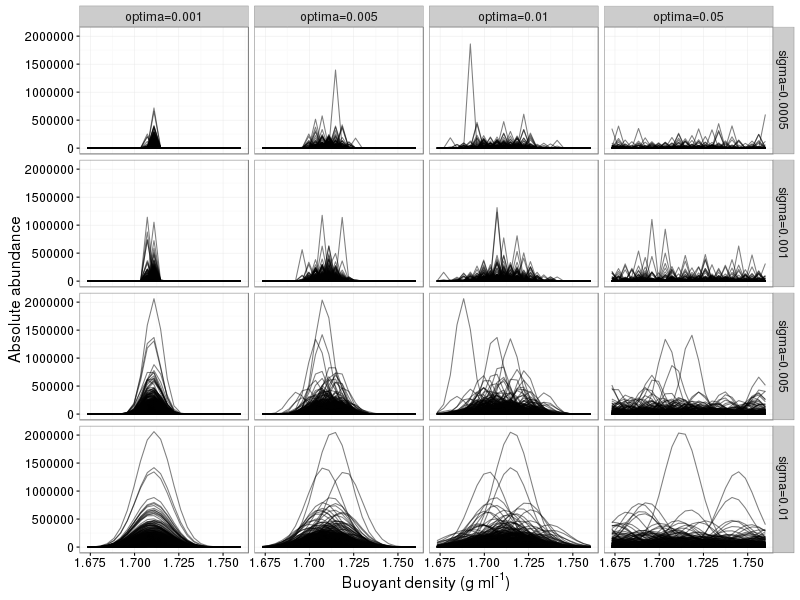

In [9]:
%%R -w 800 -h 600

x.lab = expression(paste('Buoyant density (g ml' ^ '-1', ')'))

p.abs = ggplot(df, aes(BD, count, group=taxon)) +
    geom_line(alpha=0.5) +
    facet_grid(W_lab ~ L_lab) +
    labs(x=x.lab, y='Absolute abundance') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.abs

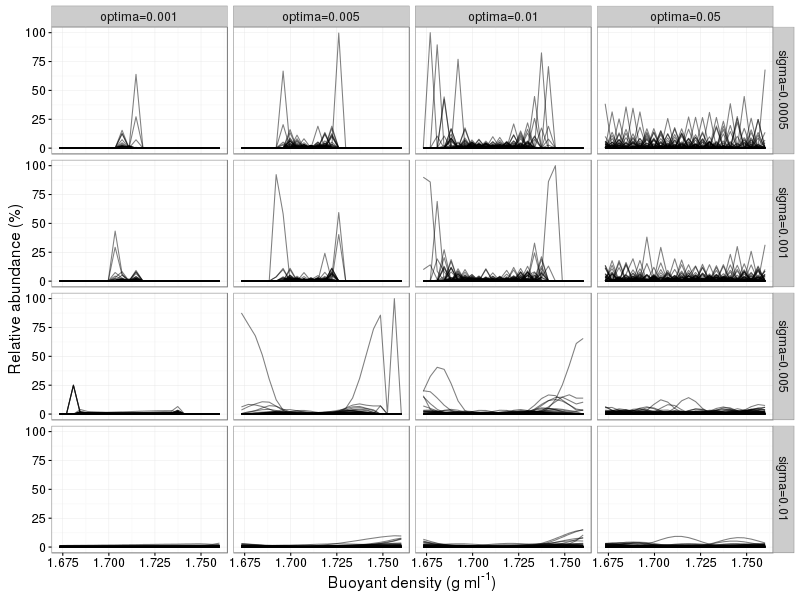

In [10]:
%%R -w 800 -h 600

p.rel = ggplot(df, aes(BD, rel_abund * 100, group=taxon)) +
    geom_line(alpha=0.5) +
    facet_grid(W_lab ~ L_lab) +
    labs(x=x.lab, y='Relative abundance (%)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.rel

### Combined plot

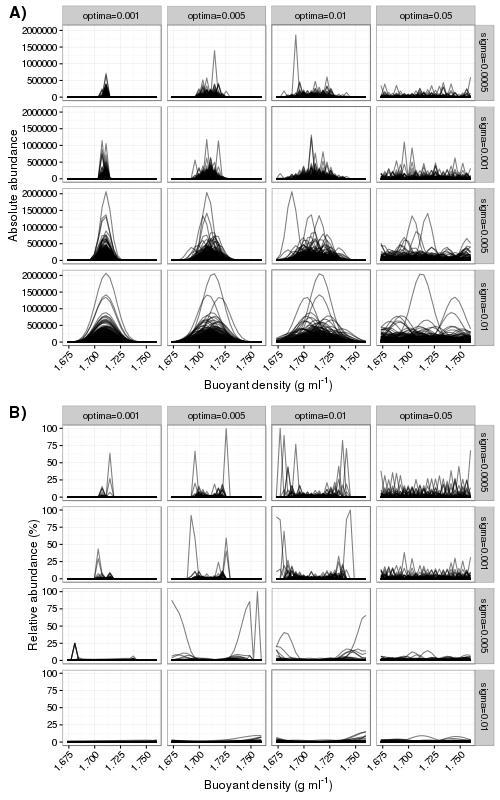

In [288]:
%%R -w 500 -h 800

p.abs.f = p.abs +
    theme(
        text=element_text(size=12),
        axis.text.x = element_text(angle=45, hjust=1)
    )
p.rel.f = p.rel +
    theme(
        text=element_text(size=12),
        axis.text.x = element_text(angle=45, hjust=1)
    )

p.comb = cowplot::ggdraw() +
    geom_rect(aes(xmin=0, ymin=0, xmax=1, ymax=1), fill='white') +
    cowplot::draw_plot(p.abs.f, 0, 0.5, 1, 0.5) +
    cowplot::draw_plot(p.rel.f, 0.04, 0, 0.96, 0.5) +
    cowplot::draw_plot_label(c('A)', 'B)'), c(0, 0), c(1, 0.5)) 

p.comb

In [290]:
%%R -i workDir
# saving plots
F = file.path(workDir, 'gaus_sim_comb.pdf') 
ggsave(F, p.comb, height=10.5, width=7)
cat('File written:', F, '\n')

File written: /home/nick/notebook/SIPSim/dev/theory/compositional//gaus_sim_comb.pdf 


# Comparing communities

### Asigning zeros

In [13]:
%%R
# giving value to missing abundances
min.pos.val = df %>%
    filter(rel_abund > 0) %>%
    group_by() %>%
    mutate(min_abund = min(rel_abund)) %>%
    ungroup() %>%
    filter(rel_abund == min_abund)

min.pos.val = min.pos.val[1,'rel_abund'] %>% as.numeric
imp.val = min.pos.val / 10


# convert numbers
#df[df$rel_abund == 0, 'rel_abund'] = imp.val

# another closure operation
df = df %>%
    mutate(rel_abund = ifelse(rel_abund == 0, imp.val, rel_abund)) %>%
    group_by(fraction, W, L) %>%
    mutate(rel_abund = rel_abund / sum(rel_abund))

# status
cat('Below detection level abundances converted to: ', imp.val, '\n')

Below detection level abundances converted to:  0.000000001620636 


## Shannon diversity

In [14]:
%%R
shannon_index_long = function(df, abundance_col, ...){
    # calculating shannon diversity index from a 'long' formated table
    ## community_col = name of column defining communities
    ## abundance_col = name of column defining taxon abundances
    df = df %>% as.data.frame
    cmd = paste0(abundance_col, '/sum(', abundance_col, ')')
    df.s = df %>%
        group_by_(...) %>%
        mutate_(REL_abundance = cmd) %>%
        mutate(pi__ln_pi = REL_abundance * log(REL_abundance),
               shannon = -sum(pi__ln_pi, na.rm=TRUE)) %>%
        ungroup() %>% 
        dplyr::select(-REL_abundance, -pi__ln_pi) %>%
        distinct_(...) 
    return(df.s)
}

In [15]:
%%R -w 700 -h 600
# calculating shannon
df.shan = shannon_index_long(df, 'count', 'fraction', 'BD', 'W', 'L')
df.shan %>% head(n=3)

Source: local data frame [3 x 10]

  taxon      W     L      BD count fraction rel_abund        W_lab        L_lab
  (chr)  (dbl) (dbl)   (dbl) (dbl)    (dbl)     (dbl)       (fctr)       (fctr)
1     1 0.0005 0.001 1.67323     0        1     0.001 sigma=0.0005 optima=0.001
2     1 0.0010 0.001 1.67323     0        1     0.001  sigma=0.001 optima=0.001
3     1 0.0050 0.001 1.67323     0        1     0.001  sigma=0.005 optima=0.001
Variables not shown: shannon (dbl)


In [17]:
%%R
# linear interpolation
#approxfun
BDs = seq(1.675, 1.76, (1.76-1.67)/19)

interp = function(df, BDs){
    F = approxfun(df$BD, df$shannon)
    x = data.frame('BD' = BDs,
                   'shannon_interp' = F(BDs))
    return(x)
}

df.shan.int = df.shan %>%
    group_by(W, L) %>%
    nest() %>%
    mutate(shannon_interp_df = lapply(data, interp, BDs=BDs)) %>%
    unnest(shannon_interp = shannon_interp_df %>% purrr::map(function(x) x)) %>%
    ungroup() %>%
    mutate(shannon_interp = ifelse(is.na(shannon_interp), 0, shannon_interp)) %>%
    mutate(W_lab = gsub('^', 'sigma=', W),
           L_lab = gsub('^', 'optima=', L),
           W_lab = W_lab %>% reorder(W),
           L_lab = L_lab %>% reorder(L)) 
        
df.shan.int %>% head(n=3)

Source: local data frame [3 x 6]

       W     L       BD shannon_interp        W_lab        L_lab
   (dbl) (dbl)    (dbl)          (dbl)       (fctr)       (fctr)
1 0.0005 0.001 1.675000              0 sigma=0.0005 optima=0.001
2 0.0005 0.001 1.679737              0 sigma=0.0005 optima=0.001
3 0.0005 0.001 1.684474              0 sigma=0.0005 optima=0.001


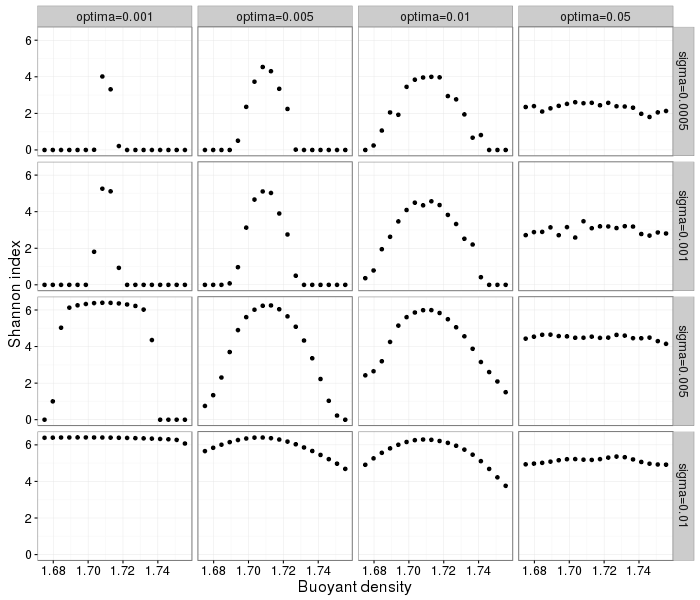

In [212]:
%%R -w 700 -h 600
# plotting
p.shan.int = ggplot(df.shan.int, aes(BD, shannon_interp)) +
    geom_point() +
    labs(x='Buoyant density', 
         y='Shannon index') +
    facet_grid(W_lab ~ L_lab) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p.shan.int

In [19]:
%%R -w 650 -h 600
# pairwise correlations for each dataset
#df.shan.bin = df.shan %>%
#    group_by(BD_bin = ntile(BD, 24)) 

calc.pearson = function(x){
    xx = x$shannon_interp.x %>% as.matrix %>% as.vector
    xy = x$shannon_interp.y %>% as.matrix %>% as.vector
    cor(xx, xy, method='pearson')
}

 
df.shan.corr = inner_join(df.shan.int, df.shan.int, c('BD' = 'BD')) %>%
    group_by(W.x, L.x, W.y, L.y) %>%
    nest() %>%
    mutate(model = purrr::map(data, calc.pearson)) %>%
    unnest(pearson = model %>% purrr::map(function(x) x)) %>%
    ungroup() %>%
    select(-data, -model) %>%
    mutate(pearson_txt = round(pearson, 2)) %>%
    unite(WL.x, W.x, L.x, sep=':', remove=FALSE) %>%
    unite(WL.y, W.y, L.y, sep=':', remove=FALSE) 
        
df.shan.corr %>% head(n=3)

Source: local data frame [3 x 8]

          WL.x    W.x   L.x         WL.y    W.y   L.y   pearson pearson_txt
         (chr)  (dbl) (dbl)        (chr)  (dbl) (dbl)     (dbl)       (dbl)
1 0.0005:0.001 0.0005 0.001 0.0005:0.001 0.0005 0.001 1.0000000        1.00
2 0.0005:0.001 0.0005 0.001  0.001:0.001 0.0010 0.001 0.9621525        0.96
3 0.0005:0.001 0.0005 0.001  0.005:0.001 0.0050 0.001 0.3010090        0.30


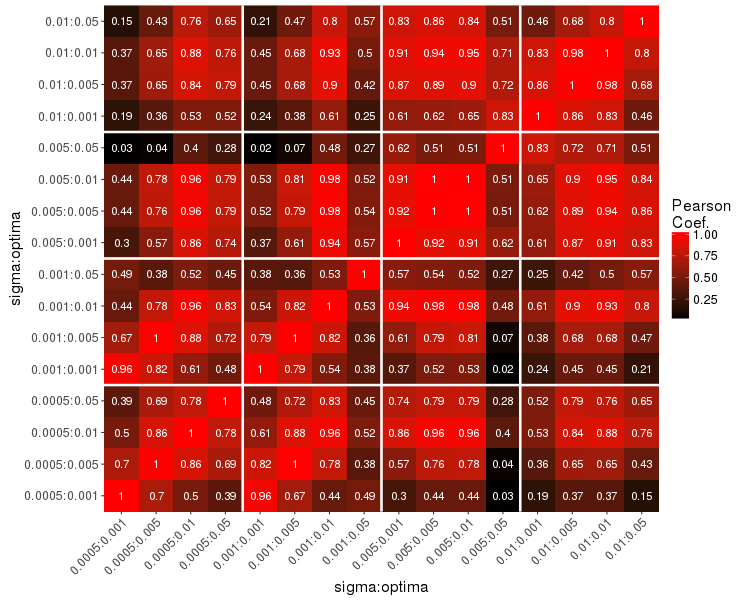

In [23]:
%%R -w 750 -h 600
z = c(4.5, 8.5, 12.5)
lab = 'sigma:optima'
ggplot(df.shan.corr, aes(WL.x, WL.y, fill=pearson)) +
    geom_tile() +
    geom_text(aes(label=pearson_txt), color='white', size=4) +
    geom_vline(xintercept=z, color='white', size=1.2) +
    geom_hline(yintercept=z, color='white', size=1.2) +
    scale_x_discrete(expand=c(0,0)) +
    scale_y_discrete(expand=c(0,0)) +
    scale_fill_gradient('Pearson\nCoef.', low='black', high='red') +
    labs(x=lab, y=lab) +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )  

## Dendrogram of pearson coef

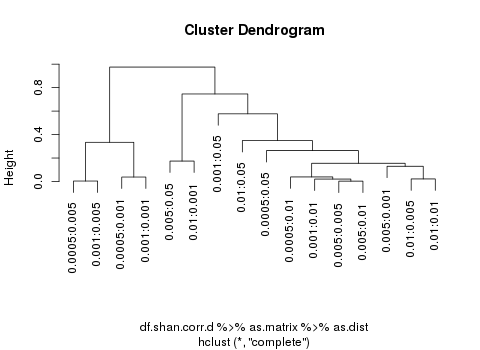

In [151]:
%%R -h 350
df.shan.corr.d = df.shan.corr %>%
    mutate(pearson_dist = 1 - pearson) %>%
    dplyr::select(WL.x, WL.y, pearson_dist) %>%
    spread(WL.y, pearson_dist) %>%
    as.data.frame

rownames(df.shan.corr.d) = df.shan.corr.d$WL.x
df.shan.corr.d$WL.x = NULL

df.shan.corr.hc = hclust(df.shan.corr.d %>% as.matrix %>% as.dist)
df.shan.corr.hc %>% plot

In [152]:
%%R
df.shan.corr.dnd = df.shan.corr.hc %>% as.dendrogram
df.shan.corr.dnd.gg = dendextend::as.ggdend(df.shan.corr.dnd)

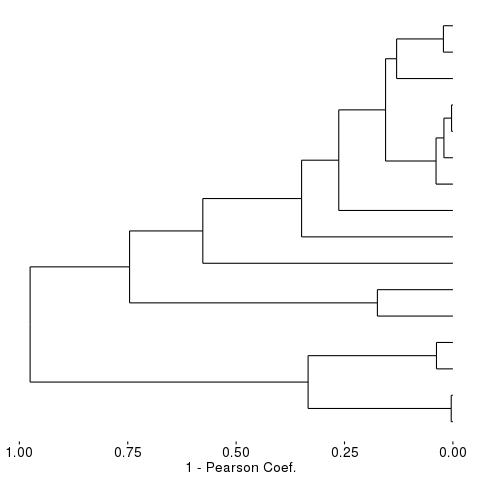

In [249]:
%%R
# plotting in ggplot
p.dnd = ggplot(df.shan.corr.dnd.gg$segments, aes(y, x)) +
    geom_segment(aes(xend=yend, yend=xend)) +
    #geom_text(data=df.shan.corr.dnd.gg$labels, aes(y-0.01, x, label=label, hjust=0)) +
    scale_x_reverse() +
    #scale_x_reverse(limits=c(1, -0.15)) +
    labs(x='1 - Pearson Coef.') +
    theme_bw() +
    theme(
            axis.title.x = element_text(size=14),
            axis.text.x = element_text(size=14),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            panel.background = element_blank(),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            legend.position = 'none',
            legend.background = element_blank(),
            legend.key = element_blank(),
            strip.background = element_blank(),
            strip.text = element_blank(),
            rect = element_rect(fill = "transparent",colour = NA)
    )
p.dnd

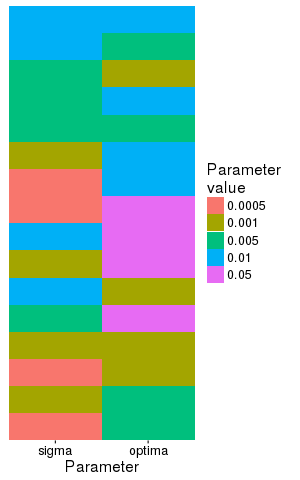

In [250]:
%%R -w 300
# adding colored bars for parameters

df.shan.corr.dnd.gg.p = df.shan.corr.dnd.gg$labels %>%
    mutate(label = label %>% as.character) %>%
    separate(label, c('sigma', 'optima'), sep=':', remove=FALSE) %>%
    gather(sig.opt, value, sigma, optima) %>%
    mutate(y = ifelse(sig.opt=='sigma', 1, 2),
           value = value %>% reorder(value %>% as.numeric),
           sig.opt = factor(sig.opt, levels=c('sigma', 'optima')))

p.bar = ggplot(df.shan.corr.dnd.gg.p, aes(sig.opt, x, fill=value)) +
    geom_tile() +
    scale_x_discrete(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    scale_fill_discrete('Parameter\nvalue') +
    labs(x='Parameter') +
    theme_bw() +
    theme(
            text = element_text(size=16),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            panel.background = element_blank(),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            legend.background = element_blank(),
            legend.key = element_blank(),
            strip.background = element_blank(),
            strip.text = element_blank()        
    )
p.bar

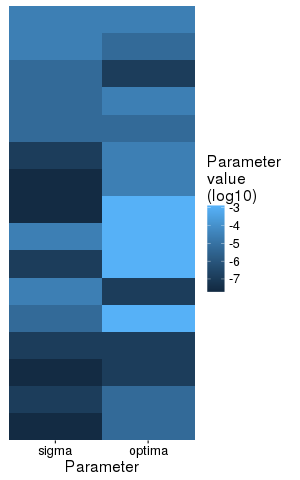

In [251]:
%%R -w 300
# adding colored bars for parameters

df.shan.corr.dnd.gg.p = df.shan.corr.dnd.gg$labels %>%
    mutate(label = label %>% as.character) %>%
    separate(label, c('sigma', 'optima'), sep=':', remove=FALSE) %>%
    gather(sig.opt, value, sigma, optima) %>%
    mutate(y = ifelse(sig.opt=='sigma', 1, 2),
           value = log(value %>% as.character %>% as.numeric),
           sig.opt = factor(sig.opt, levels=c('sigma', 'optima')))

p.bar = ggplot(df.shan.corr.dnd.gg.p, aes(sig.opt, x, fill=value)) +
    geom_tile() +
    scale_x_discrete(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    scale_fill_continuous('Parameter\nvalue\n(log10)') +
    labs(x='Parameter') +
    theme_bw() +
    theme(
            text = element_text(size=16),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            panel.background = element_blank(),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            legend.background = element_blank(),
            legend.key = element_blank(),
            strip.background = element_blank(),
            strip.text = element_blank(),
            rect = element_rect(fill = "transparent",colour = NA)
    )
p.bar

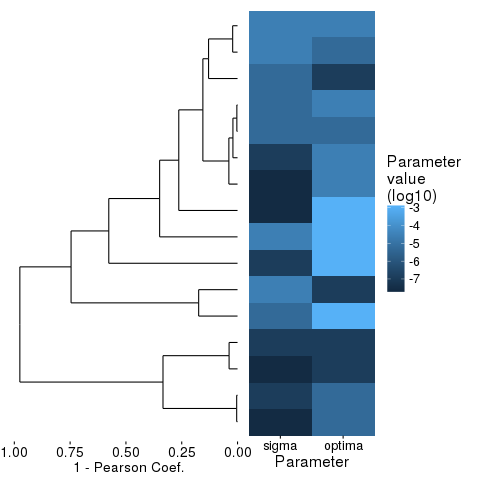

In [252]:
%%R
p.shan.dnd = cowplot::ggdraw() +
    geom_rect(aes(xmin=0, ymin=0, xmax=1, ymax=1), fill='white') +
    cowplot::draw_plot(p.dnd, 0, 0, 0.53, 1) +
    cowplot::draw_plot(p.bar, 0.5, 0.01, 0.5, 0.98) 
p.shan.dnd

In [253]:
%%R -w 750 -h 600
# # pairwise correlations for each dataset
# df.shan.bin = df.shan %>%
#     group_by(BD_bin = ntile(BD, 24)) %>%
#     mutate(n=n()) %>%
#     ungroup()
#     #unite(dataset, W, L, sep=':', remove=FALSE)


# calc.pearson = function(x){
#     cor(x[,'shannon.x'], x['shannon.y'], method='pearson')[1,1]
# }
# as.num = function(x) x %>% as.character %>% as.numeric
 

# df.shan.corr = inner_join(df.shan.bin, df.shan.bin, c('BD_bin' = 'BD_bin')) %>%
#     group_by(W.x, L.x, W.y, L.y) %>%
#     nest() %>%
#     mutate(model = purrr::map(data, calc.pearson)) %>%
#     unnest(pearson = model %>% purrr::map(function(x) x))  %>%
#     ungroup() %>%
#     select(-data, -model) %>%
#     mutate(pearson_txt = round(pearson, 2)) %>%
#     unite(WL.x, W.x, L.x, sep=':', remove=FALSE) %>%
#     unite(WL.y, W.y, L.y, sep=':', remove=FALSE) 

# # plotting
# #sig = rep(c(0.0005, 0.001, 0.005, 0.01), 4) %>% sort
# #opt = rep(c(0.001, 0.005, 0.01, 0.05), 4) %>% sort

# #lab = 'sigma:optima'
# ggplot(df.shan.corr, aes(WL.x, WL.y, fill=pearson)) +
#     geom_tile() +
#     geom_text(aes(label=pearson_txt), color='white', size=4) +
#     scale_x_discrete(expand=c(0,0)) +
#     scale_y_discrete(expand=c(0,0)) +
#     scale_fill_gradient('Pearson\nCoef.', low='black', high='red') +
# #    facet_grid(W.y ~ L.x) +
#     labs(x='sigma', y='optima') +
#     #labs(x=lab, y=lab) +
#     theme(
#         text = element_text(size=16),
#         axis.text.x = element_text(angle=45, hjust=1)
#     )  

NULL


In [254]:
%%R -w 750 -h 600
# # pairwise correlations for each dataset
# df.shan.bin = df.shan %>%
#     group_by(BD_bin = ntile(BD, 24)) %>%
#     unite(dataset, W, L, sep=':', remove=FALSE)


# calc.pearson = function(x){
#     cor(x[,'shannon.x'], x['shannon.y'], method='pearson')[1,1]
# }
# as.num = function(x) x %>% as.character %>% as.numeric
 

# df.shan.corr = inner_join(df.shan.bin, df.shan.bin, c('BD_bin' = 'BD_bin')) %>%
#     group_by(dataset.x, dataset.y) %>%
#     nest() %>%
#     mutate(model = purrr::map(data, calc.pearson)) %>%
#     unnest(pearson = model %>% purrr::map(function(x) x)) %>%
#     ungroup() %>%
#     select(-data, -model) %>%
#     mutate(pearson_txt = round(pearson, 2))
#           # dataset.y.opt = gsub('.+:', '', dataset.y) %>% as.numeric,
#            #dataset.y = dataset.y %>% reorder(dataset.y.opt),
#           # dataset.x.sig = gsub(':.+', '', dataset.x) %>% as.numeric,
#           # dataset.x = dataset.x %>% reorder(dataset.x.sig))
    

# # plotting
# z = c(4.5, 8.5, 12.5)
# #sig = rep(c(0.0005, 0.001, 0.005, 0.01), 4) %>% sort
# #opt = rep(c(0.001, 0.005, 0.01, 0.05), 4) %>% sort

# lab = 'sigma:optima'
# ggplot(df.shan.corr, aes(dataset.x, dataset.y, fill=pearson)) +
#     geom_tile() +
#     geom_text(aes(label=pearson_txt), color='white', size=4.5) +
#     geom_vline(xintercept=z, color='white', size=1.2) +
#     geom_hline(yintercept=z, color='white', size=1.2) +
#     scale_x_discrete(expand=c(0,0)) +
#     scale_y_discrete(expand=c(0,0)) +
#     scale_fill_gradient('Pearson\nCoef.', low='black', high='red') +
#     #facet_grid(dataset.y.opt ~ dataset.x.sig) +
#     #labs(x='sigma', y='optima') +
#     labs(x=lab, y=lab) +
#     theme(
#         text = element_text(size=16),
#         axis.text.x = element_text(angle=45, hjust=1)
#     ) 

NULL


## Combined plot

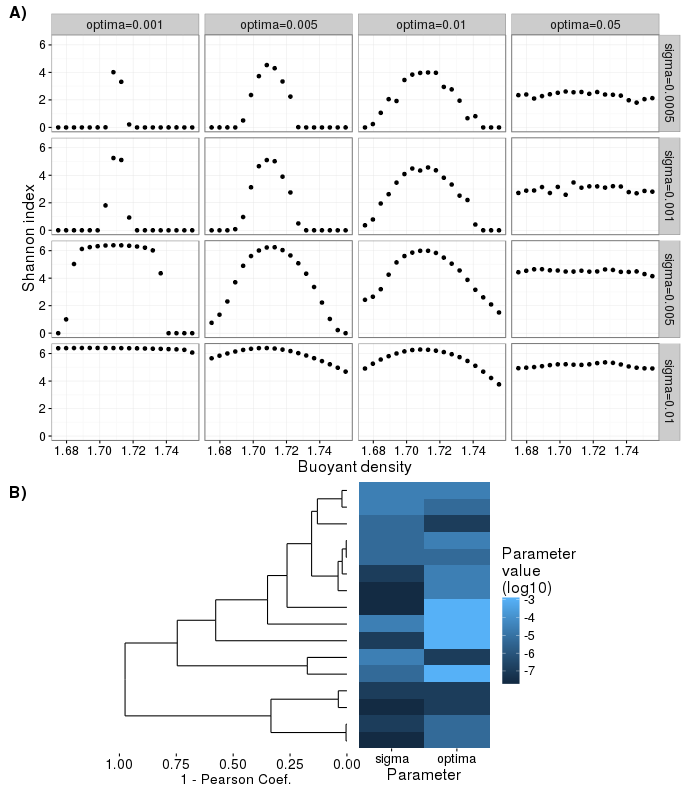

In [258]:
%%R -w 700 -h 800
p.shan.comb = cowplot::ggdraw() +
    geom_rect(aes(xmin=0, ymin=0, xmax=1, ymax=1), fill='white') +
    cowplot::draw_plot(p.shan.int, 0.02, 0.40, 0.96, 0.59) +
    cowplot::draw_plot(p.dnd, 0.15, 0.01, 0.37, 0.4) +
    cowplot::draw_plot(p.bar, 0.5, 0.015, 0.35, 0.39) +
    cowplot::draw_plot_label(c('A)', 'B)'), c(0, 0), c(1, 0.4))
p.shan.comb

In [259]:
%%R -i workDir
# saving plot
F = file.path(workDir, 'compData_shan.pdf')
ggsave(F, p.shan.comb, height=10, width=9)
cat('File written:', F, '\n')

File written: /home/nick/notebook/SIPSim/dev/theory/compositional//compData_shann.pdf 


# Correlograms

In [160]:
%%R

BD.diffs = function(df){
    BDs = df$BD %>% unique
    df.BD = expand.grid(BDs, BDs)
    df.BD$diff = df.BD %>% apply(1, diff) %>% abs %>% as.vector    
    df.BD = df.BD %>% spread(Var1, diff) 
    rownames(df.BD) = df.BD$Var2
    df.BD$Var2 = NULL
    dist.BD = df.BD %>% as.matrix
    dist.BD[upper.tri(dist.BD, diag=TRUE)] = 0
    dist.BD %>% as.dist
    }

vegdist.by = function(df, ...){
    df.w = df %>%
        select(taxon, rel_abund, fraction, BD) %>%
        spread(taxon, rel_abund) %>%
        as.data.frame()
    
    rownames(df.w) = df.w$BD %>% as.vector
    df.w$BD = NULL
    df.w$fraction = NULL
    
    vegan::vegdist(df.w, ...)
}


dist.match = function(X,D){
    # making sure matrices match
    X.m = X %>% as.matrix
    D.m = D %>% as.matrix
    d = setdiff(rownames(X.m), rownames(D.m))
    if(length(d) > 0){
        print(rownames(X.m))
        print(rownames(D.m))
        print(d)
        stop('Distance matrices don\'t match')
    }
    D.m = D.m[rownames(X.m), colnames(X.m)] 
    D = D.m %>% as.dist
    return(D)
    }

m.corr = function(X, D, ...){
    res = list()
    for (i in 1:length(X)){
        X.d = X[[i]]
        X.d[is.na(X.d)] = 0
        D.d = D[[i]]
        D.d = dist.match(X.d, D.d)
        tmp = vegan::mantel.correlog(X.d, D.d, ...)
        tmp = tmp['mantel.res'][['mantel.res']] %>% as.data.frame
        colnames(tmp) = c('class.index', 'n.dist', 'Mantel.corr', 'Pr', 'Pr.corr')
        res[[i]] = tmp
    }
    return(res)
}

# running
df.d = df %>%
    ungroup() %>%
    group_by(W, L) %>%
    nest() %>%
    mutate(dist.bray = lapply(data, vegdist.by),
           dist.BD = lapply(data, BD.diffs),
           mantel.corr = m.corr(dist.bray, dist.BD, n.class=24)) %>%
    select(W, L, mantel.corr) %>%
    unnest(mantel.corr %>% purrr::map(function(x) x)) 
df.d %>% head

Source: local data frame [6 x 7]

       W     L class.index n.dist Mantel.corr    Pr Pr.corr
   (dbl) (dbl)       (dbl)  (dbl)       (dbl) (dbl)   (dbl)
1 0.0005 0.001 0.005501721     46  0.02426468 0.056   0.056
2 0.0005 0.001 0.008959946     44  0.01203201 0.390   0.390
3 0.0005 0.001 0.012418170     42 -0.02861663 0.271   0.542
4 0.0005 0.001 0.015876395     40 -0.03687200 0.205   0.615
5 0.0005 0.001 0.019334620     38 -0.04554459 0.127   0.508
6 0.0005 0.001 0.022792844     36 -0.05468814 0.077   0.385


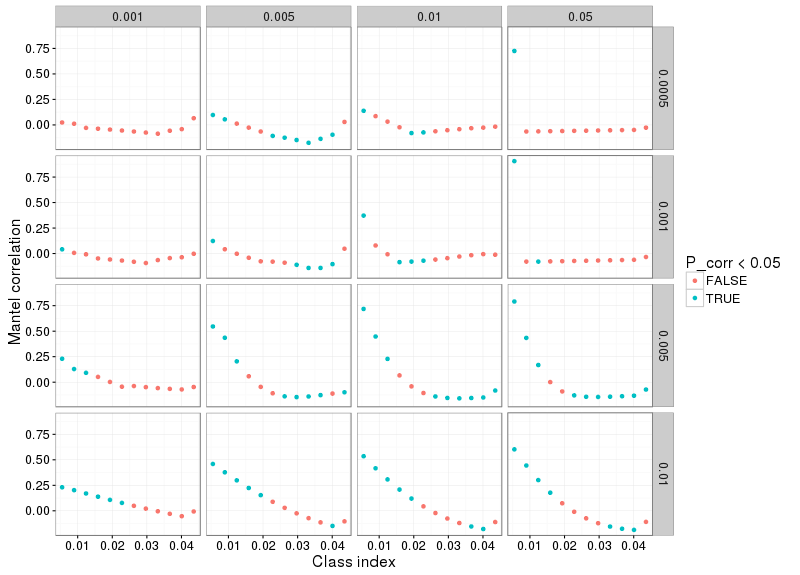

In [161]:
%%R -w 800 -h 575
df.d.s = df.d %>%
    filter(! is.na(Mantel.corr)) %>%
    ungroup() %>%
    mutate(significant = ifelse(Pr.corr <= 0.05, TRUE, FALSE))


ggplot(df.d.s, aes(class.index, Mantel.corr, color=significant)) +
    geom_point() +
    scale_color_discrete('P_corr < 0.05') +
    labs(x='Class index', y='Mantel correlation') +
    facet_grid(W ~ L) +
    theme_bw() +
    theme( 
        text = element_text(size=16)
    ) 

In [162]:
%%R -w 750 -h 600
# pairwise correlations for each dataset
df.d.bin = df.d %>%
    group_by(BD_bin = ntile(class.index, 12)) %>%
    unite(dataset, W, L, sep=':', remove=FALSE)

df.d.bin %>% head

Source: local data frame [6 x 9]
Groups: BD_bin [3]

       dataset      W     L class.index n.dist Mantel.corr    Pr Pr.corr BD_bin
         (chr)  (dbl) (dbl)       (dbl)  (dbl)       (dbl) (dbl)   (dbl)  (int)
1 0.0005:0.001 0.0005 0.001 0.005501721     46  0.02426468 0.056   0.056      1
2 0.0005:0.001 0.0005 0.001 0.008959946     44  0.01203201 0.390   0.390      1
3 0.0005:0.001 0.0005 0.001 0.012418170     42 -0.02861663 0.271   0.542      2
4 0.0005:0.001 0.0005 0.001 0.015876395     40 -0.03687200 0.205   0.615      2
5 0.0005:0.001 0.0005 0.001 0.019334620     38 -0.04554459 0.127   0.508      3
6 0.0005:0.001 0.0005 0.001 0.022792844     36 -0.05468814 0.077   0.385      3


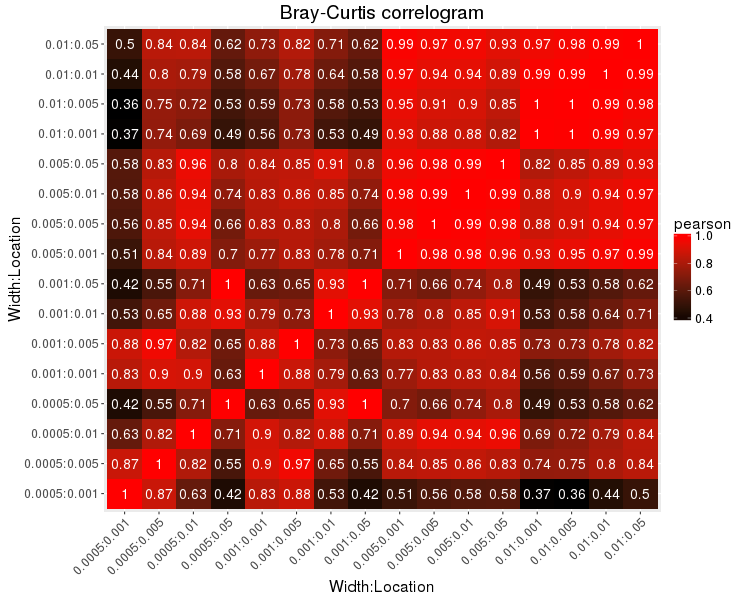

In [163]:
%%R -w 750 -h 600
# pairwise correlations for each dataset
df.d.bin = df.d %>%
    filter(! is.na(Mantel.corr)) %>%
    group_by(BD_bin = ntile(class.index, 12)) %>%
    unite(dataset, W, L, sep=':', remove=FALSE) %>%
    as.data.frame


calc.pearson = function(x){
    ret = cor(x[,'Mantel.corr.x'], x[,'Mantel.corr.y'], method='pearson')[1,1]
    return(ret)
}
as.num = function(x) x %>% as.character %>% as.numeric
 

df.d.corr = inner_join(df.d.bin, df.d.bin, c('BD_bin' = 'BD_bin')) %>%
    group_by(dataset.x, dataset.y) %>%
    nest() %>%
    mutate(model = purrr::map(data, calc.pearson)) %>%
    unnest(pearson = model %>% purrr::map(function(x) x)) %>%
    ungroup() %>%
    select(-data, -model) %>%
    mutate(pearson_txt = round(pearson, 2))
        
 # plotting
lab = 'Width:Location'        
ggplot(df.d.corr, aes(dataset.x, dataset.y, fill=pearson)) +
    geom_tile() +
    geom_text(aes(label=pearson_txt), color='white', size=5) +
    scale_fill_gradient(low='black', high='red') +
    labs(x=lab, y=lab, title='Bray-Curtis correlogram') +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    ) 

## Dendrogram of Pearson values

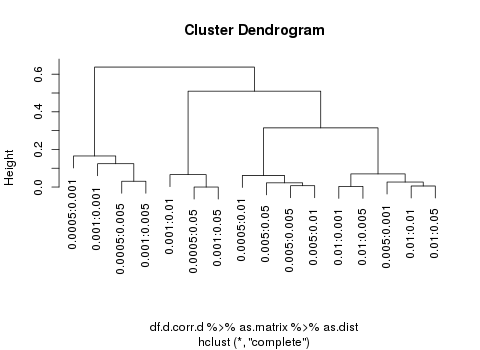

In [176]:
%%R -h 350
df.d.corr.d = df.d.corr %>%
    mutate(pearson_dist = 1 - pearson) %>%
    dplyr::select(dataset.x, dataset.y, pearson_dist) %>%
    spread(dataset.y, pearson_dist) %>%
    as.data.frame

rownames(df.d.corr.d) = df.d.corr.d$dataset.x
df.d.corr.d$dataset.x = NULL

df.d.corr.hc = hclust(df.d.corr.d %>% as.matrix %>% as.dist, method='complete')
df.d.corr.hc %>% plot

In [177]:
%%R
df.d.corr.dnd = df.d.corr.hc %>% as.dendrogram
df.d.corr.dnd.gg = dendextend::as.ggdend(df.d.corr.dnd)

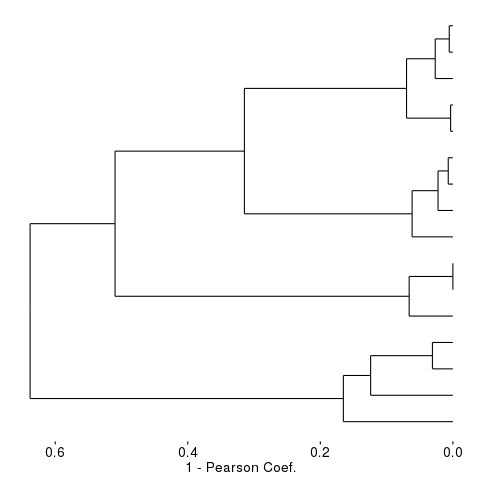

In [178]:
%%R
# plotting in ggplot
p.dnd = ggplot(df.d.corr.dnd.gg$segments, aes(y, x)) +
    geom_segment(aes(xend=yend, yend=xend)) +
    #geom_text(data=df.shan.corr.dnd.gg$labels, aes(y-0.01, x, label=label, hjust=0)) +
    scale_x_reverse() +
    #scale_x_reverse(limits=c(1, -0.15)) +
    labs(x='1 - Pearson Coef.') +
    theme_bw() +
    theme(
            axis.title.x = element_text(size=14),
            axis.text.x = element_text(size=14),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            panel.background = element_blank(),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            legend.position = 'none',
            legend.background = element_blank(),
            legend.key = element_blank(),
            strip.background = element_blank(),
            strip.text = element_blank()
    )
p.dnd

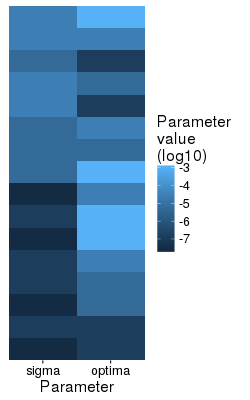

In [179]:
%%R -w 250 -h 400
# adding colored bars for parameters

df.d.corr.dnd.gg.p = df.d.corr.dnd.gg$labels %>%
    mutate(label = label %>% as.character) %>%
    separate(label, c('sigma', 'optima'), sep=':', remove=FALSE) %>%
    gather(sig.opt, value, sigma, optima) %>%
    mutate(y = ifelse(sig.opt=='sigma', 1, 2),
           value = log(value %>% as.character %>% as.numeric),
           sig.opt = factor(sig.opt, levels=c('sigma', 'optima')))

p.bar = ggplot(df.d.corr.dnd.gg.p, aes(sig.opt, x, fill=value)) +
    geom_tile() +
    scale_x_discrete(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    scale_fill_continuous('Parameter\nvalue\n(log10)') +
    labs(x='Parameter') +
    theme_bw() +
    theme(
            text = element_text(size=16),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            panel.background = element_blank(),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            legend.background = element_blank(),
            legend.key = element_blank(),
            strip.background = element_blank(),
            strip.text = element_blank()        
    )
p.bar

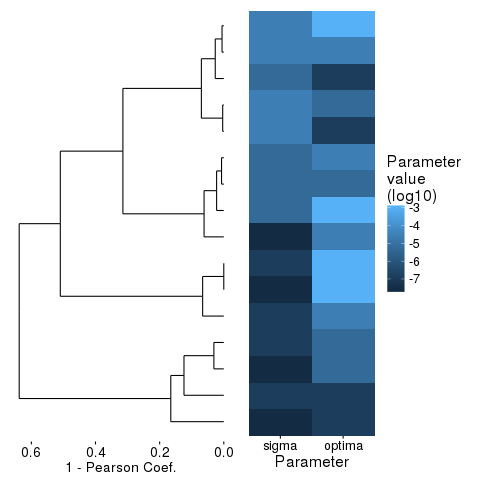

In [180]:
%%R
p.d.dnd = cowplot::ggdraw() +
    geom_rect(aes(xmin=0, ymin=0, xmax=1, ymax=1), fill='white') +
    cowplot::draw_plot(p.dnd, 0, 0, 0.50, 1) +
    cowplot::draw_plot(p.bar, 0.5, 0.01, 0.5, 0.98) 
p.d.dnd

# Correlograms: Jaccard

In [260]:
%%R
# running
df.d = df %>%
    ungroup() %>%
    group_by(W, L) %>%
    nest() %>%
    mutate(dist.bray = lapply(data, vegdist.by, method='jaccard'),
           dist.BD = lapply(data, BD.diffs),
           mantel.corr = m.corr(dist.bray, dist.BD, n.class=24)) %>%
    select(W, L, mantel.corr) %>%
    unnest(mantel.corr %>% purrr::map(function(x) x)) 
df.d %>% head

Source: local data frame [6 x 7]

       W     L class.index n.dist Mantel.corr    Pr Pr.corr
   (dbl) (dbl)       (dbl)  (dbl)       (dbl) (dbl)   (dbl)
1 0.0005 0.001 0.005501721     46  0.03340746 0.060   0.060
2 0.0005 0.001 0.008959946     44  0.01079532 0.383   0.383
3 0.0005 0.001 0.012418170     42 -0.02995485 0.282   0.564
4 0.0005 0.001 0.015876395     40 -0.03838491 0.212   0.636
5 0.0005 0.001 0.019334620     38 -0.04724158 0.147   0.588
6 0.0005 0.001 0.022792844     36 -0.05657980 0.087   0.435


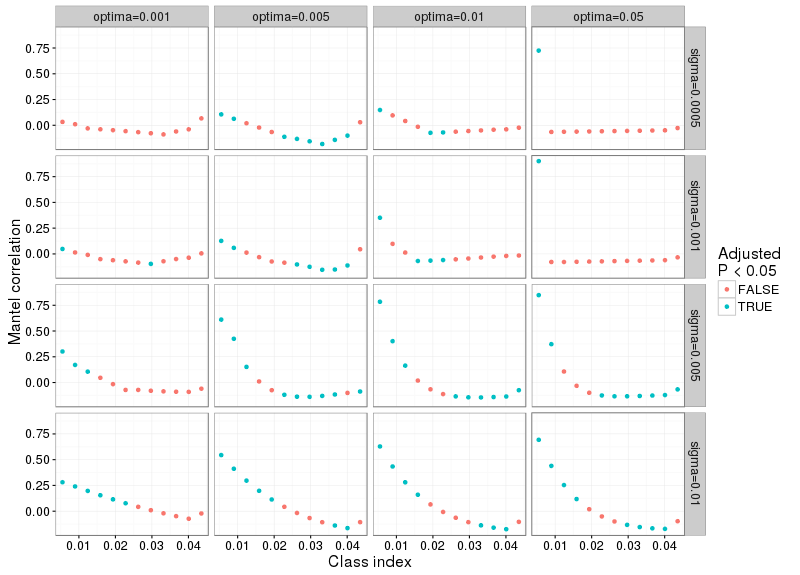

In [277]:
%%R -w 800 -h 575
df.d.s = df.d %>%
    filter(! is.na(Mantel.corr)) %>%
    ungroup() %>%
    mutate(significant = ifelse(Pr.corr <= 0.05, TRUE, FALSE),
           W_lab = gsub('^', 'sigma=', W),
           L_lab = gsub('^', 'optima=', L))


p.cor = ggplot(df.d.s, aes(class.index, Mantel.corr, color=significant)) +
    geom_point() +
    scale_color_discrete('Adjusted\nP < 0.05') +
    labs(x='Class index', y='Mantel correlation') +
    facet_grid(W_lab ~ L_lab) +
    theme_bw() +
    theme( 
        text = element_text(size=16)
    )
p.cor

In [262]:
%%R -w 750 -h 600
# pairwise correlations for each dataset
df.d.bin = df.d %>%
    group_by(BD_bin = ntile(class.index, 12)) %>%
    unite(dataset, W, L, sep=':', remove=FALSE)

df.d.bin %>% head

Source: local data frame [6 x 9]
Groups: BD_bin [3]

       dataset      W     L class.index n.dist Mantel.corr    Pr Pr.corr BD_bin
         (chr)  (dbl) (dbl)       (dbl)  (dbl)       (dbl) (dbl)   (dbl)  (int)
1 0.0005:0.001 0.0005 0.001 0.005501721     46  0.03340746 0.060   0.060      1
2 0.0005:0.001 0.0005 0.001 0.008959946     44  0.01079532 0.383   0.383      1
3 0.0005:0.001 0.0005 0.001 0.012418170     42 -0.02995485 0.282   0.564      2
4 0.0005:0.001 0.0005 0.001 0.015876395     40 -0.03838491 0.212   0.636      2
5 0.0005:0.001 0.0005 0.001 0.019334620     38 -0.04724158 0.147   0.588      3
6 0.0005:0.001 0.0005 0.001 0.022792844     36 -0.05657980 0.087   0.435      3


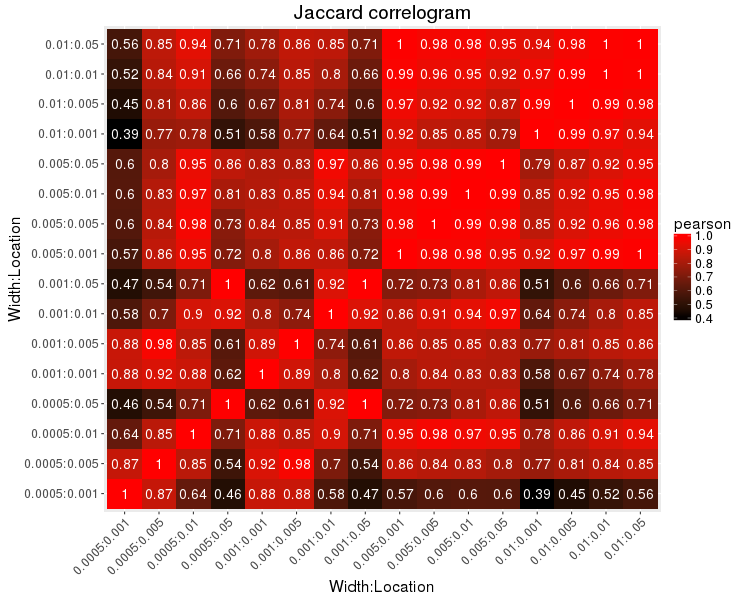

In [266]:
%%R -w 750 -h 600
# pairwise correlations for each dataset
df.d.bin = df.d %>%
    filter(! is.na(Mantel.corr)) %>%
    group_by(BD_bin = ntile(class.index, 12)) %>%
    unite(dataset, W, L, sep=':', remove=FALSE) %>%
    as.data.frame


calc.pearson = function(x){
    ret = cor(x[,'Mantel.corr.x'], x[,'Mantel.corr.y'], method='pearson')[1,1]
    return(ret)
}
as.num = function(x) x %>% as.character %>% as.numeric
 

df.d.corr = inner_join(df.d.bin, df.d.bin, c('BD_bin' = 'BD_bin')) %>%
    group_by(dataset.x, dataset.y) %>%
    nest() %>%
    mutate(model = purrr::map(data, calc.pearson)) %>%
    unnest(pearson = model %>% purrr::map(function(x) x)) %>%
    ungroup() %>%
    select(-data, -model) %>%
    mutate(pearson_txt = round(pearson, 2))
        
 # plotting
lab = 'Width:Location'        
ggplot(df.d.corr, aes(dataset.x, dataset.y, fill=pearson)) +
    geom_tile() +
    geom_text(aes(label=pearson_txt), color='white', size=5) +
    scale_fill_gradient(low='black', high='red') +
    labs(x=lab, y=lab, title='Jaccard correlogram') +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    ) 

## Dendrogram of Pearson coef

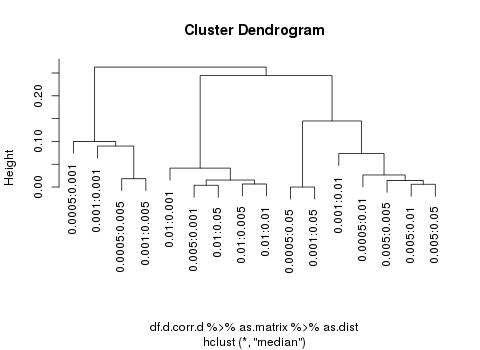

In [267]:
%%R -h 350
df.d.corr.d = df.d.corr %>%
    mutate(pearson_dist = 1 - pearson) %>%
    dplyr::select(dataset.x, dataset.y, pearson_dist) %>%
    spread(dataset.y, pearson_dist) %>%
    as.data.frame

rownames(df.d.corr.d) = df.d.corr.d$dataset.x
df.d.corr.d$dataset.x = NULL

df.d.corr.hc = hclust(df.d.corr.d %>% as.matrix %>% as.dist, method='median')
df.d.corr.hc %>% plot

In [268]:
%%R
df.d.corr.dnd = df.d.corr.hc %>% as.dendrogram
df.d.corr.dnd.gg = dendextend::as.ggdend(df.d.corr.dnd)

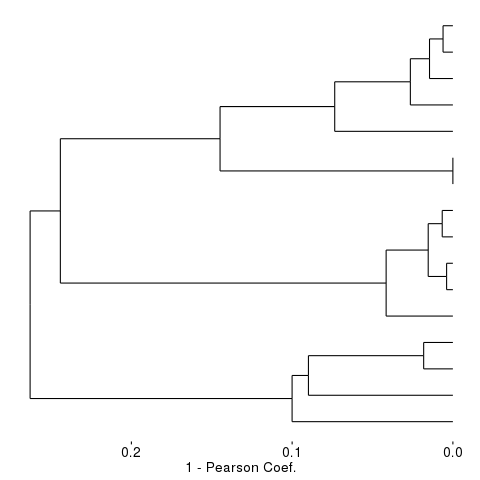

In [269]:
%%R
# plotting in ggplot
p.dnd = ggplot(df.d.corr.dnd.gg$segments, aes(y, x)) +
    geom_segment(aes(xend=yend, yend=xend)) +
    #geom_text(data=df.shan.corr.dnd.gg$labels, aes(y-0.01, x, label=label, hjust=0)) +
    scale_x_reverse() +
    #scale_x_reverse(limits=c(1, -0.15)) +
    labs(x='1 - Pearson Coef.') +
    theme_bw() +
    theme(
            axis.title.x = element_text(size=14),
            axis.text.x = element_text(size=14),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            panel.background = element_blank(),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            legend.position = 'none',
            legend.background = element_blank(),
            legend.key = element_blank(),
            strip.background = element_blank(),
            strip.text = element_blank(),
            rect = element_rect(fill = "transparent",colour = NA)
    )
p.dnd

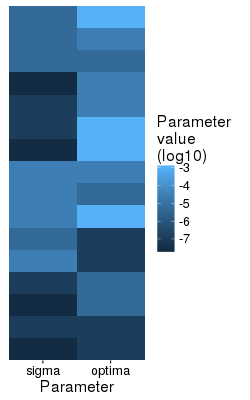

In [270]:
%%R -w 250 -h 400
# adding colored bars for parameters

df.d.corr.dnd.gg.p = df.d.corr.dnd.gg$labels %>%
    mutate(label = label %>% as.character) %>%
    separate(label, c('sigma', 'optima'), sep=':', remove=FALSE) %>%
    gather(sig.opt, value, sigma, optima) %>%
    mutate(y = ifelse(sig.opt=='sigma', 1, 2),
           value = log(value %>% as.character %>% as.numeric),
           sig.opt = factor(sig.opt, levels=c('sigma', 'optima')))

p.bar = ggplot(df.d.corr.dnd.gg.p, aes(sig.opt, x, fill=value)) +
    geom_tile() +
    scale_x_discrete(expand=c(0,0)) +
    scale_y_continuous(expand=c(0,0)) +
    scale_fill_continuous('Parameter\nvalue\n(log10)') +
    labs(x='Parameter') +
    theme_bw() +
    theme(
            text = element_text(size=16),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            panel.background = element_blank(),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            legend.background = element_blank(),
            legend.key = element_blank(),
            strip.background = element_blank(),
            strip.text = element_blank(),
            rect = element_rect(fill = "transparent",colour = NA)
    )
p.bar

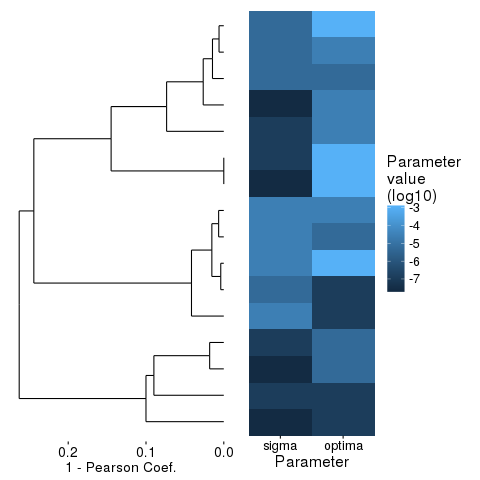

In [271]:
%%R
p.d.dnd = cowplot::ggdraw() +
    geom_rect(aes(xmin=0, ymin=0, xmax=1, ymax=1), fill='white') +
    cowplot::draw_plot(p.dnd, 0, 0, 0.50, 1) +
    cowplot::draw_plot(p.bar, 0.5, 0.01, 0.5, 0.98) 
p.d.dnd

## Combined plot

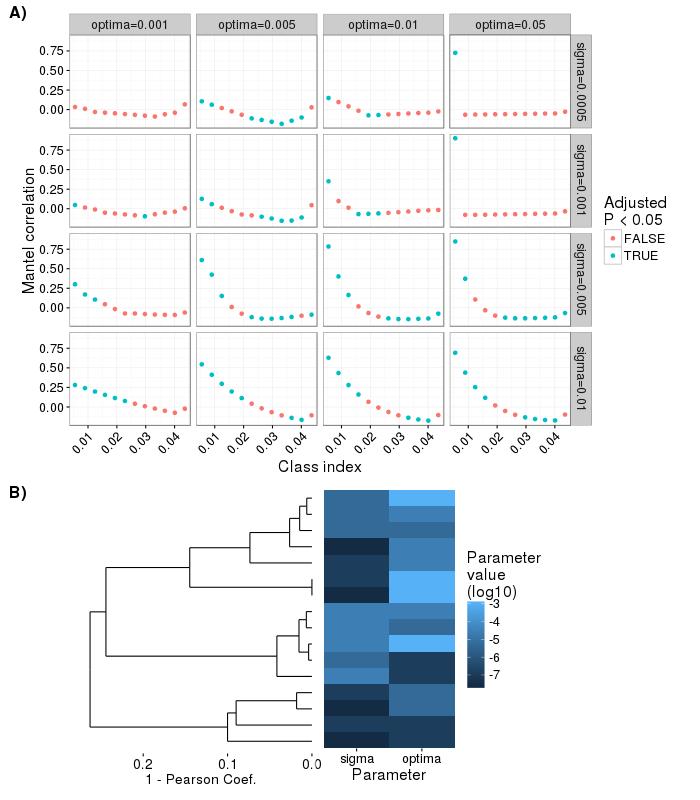

In [286]:
%%R -w 700 -h 800
p.cor.f = p.cor + 
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

p.cor.comb = cowplot::ggdraw() +
    geom_rect(aes(xmin=0, ymin=0, xmax=1, ymax=1), fill='white') +
    cowplot::draw_plot(p.cor.f, 0.02, 0.40, 0.96, 0.59) +
    cowplot::draw_plot(p.dnd, 0.1, 0.01, 0.37, 0.39) +
    cowplot::draw_plot(p.bar, 0.45, 0.015, 0.35, 0.38) +
    cowplot::draw_plot_label(c('A)', 'B)'), c(0, 0), c(1, 0.4))
p.cor.comb

In [287]:
%%R -i workDir
# saving plot
F = file.path(workDir, 'compData_correlogram.pdf')
ggsave(F, p.cor.comb, height=10.5, width=9)
cat('File written:', F, '\n')

File written: /home/nick/notebook/SIPSim/dev/theory/compositional//compData_correlogram.pdf 


***
***